# Importando as bibliotecas

In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
# André Vinícius Rocha Pires
# 10737290
# Bibliotecas
import numpy as np #biblioteca para lidar com matrizes
import matplotlib.pyplot as plt #biblioteca para plotar gráficos
from math import sqrt #importando a função raiz

# O Determinante

Calcular o determinante de uma matriz é uma operação muito cara. Durante o desenvolvimento do código, o "profiler" da IDE sempre acusava esta função como sendo responsável por $99,9\%$ do tempo de execução. Os maiores gargalos eram a inicialização das matrizes menores e o "append" dos pedaços da orinal nas submatrizes. Foi possível melhorar o "append", quer dizer, a transferência dos dados da matriz original para a matriz menor, usando associação simples. Depois, a inicialização das submatrizes, que antes era feita com zeros como valor inicial, passou a ser feita sem definir valores. Conseguimos uma queda de aproximadamente $40\%$ no tempo de execução, mas ainda era muito (ainda $99,9\%$). Então, para melhorar a performance de nosso código como um todo, usamos o recurso de sempre usar matrizes triangulares para calcular o determinante. O algoritmo está aqui em sua versão completa, usando o Teorema de Laplace, mas tem uma condição onde primeiro é checado se a matriz é triangular. A redução de tempo obtida por esta técnica é da ordem de $O(n!)$ para $O(n) + O(n^3)$, onde $O(n^3)$ é a complexidade para triangularizar a matriz. Percebemos este atalho como sendo de considerável importância para a economia de recursos, uma vez que a triangularização sempre será executada e, mesmo quando não obtiver sucesso, será uma técnica mais barata para identificar a singularidade da matriz.

In [1]:
def is_triangular(matrix):
    
  #função que checa se a matriz é triangular
  n = np.size(matrix, axis = 0)
  upper = False
  triangular = True

  #checa se é triangular superior, inferior, ou se não é triangular
  for i in range(n):
    for j in range(i):
      if matrix[i,j] != 0:
        upper = True
  if upper:
    for i in range(n-1,-1,-1):
      for j in range(i+1, n):
        if matrix[i,j] != 0:
          upper = False
          triangular = False
          return(triangular, upper)
  return(triangular, upper)

In [64]:
def determinant(#matriz a ser calculada
                matrix,
                #cofator
                mul = 1):
 
  #tamanho da matriz a ser calculada
  n = np.size(matrix, axis = 0)
 
  #checa se a matriz é triangular. se sim, o trabalho é menor
  if is_triangular(matrix):
    #basta multiplicar os elementos da diagonal
    d = matrix[0,0]
    for i in range(1, n):
      d *= matrix[i,i]
    return d
  else:
    #se a matriz não é triangular, usamos o Teorema de Laplace
    if n == 1:
      return mul * matrix[0,0]
    else:
      sign = -1
      sum = 0
      for i in range(n):
        m = np.empty([n-1, n-1])#a operação mais cara da função
        #trecho onde o "append" foi substituído por associação simples 
        m[0:n-1, 0:i] = matrix[1:n, 0:i]
        m[0:n-1, i:n-1] = matrix[1:n, i+1:n]
        sign *= -1
        sum += mul * determinant(m, sign * matrix[0, i])
      return sum

# Eliminação de Gauss

Aqui, temos um algoritmo de Eliminação de Gauss que troca linhas sempre que necessário. Se as trocas de linhas não solucionam um problema de pivô nulo, o algoritmo encerra a execução indicando que a matriz é singular. Este foi o recurso usado para checar a singularidade da matriz, como um atalho ao uso do determinante, por economia de recursos. O sucesso na execução da Eliminação tem a dupla vantagem de preparar a solução do problema e facilitar o cálculo do determinante. O algoritmo oferece outra opção de regra de troca de linhas, o "Pivotamento Parcial", e também fatoriza a matriz na forma $A = LU$.

In [65]:
def rowchange(augm, n, k, pivoting = False):
  #check for pivoting possibilities
  if all(augm[k:, k] == 0):
    return    
  #pivoting strategies
  #partial pivoting strategy
  if pivoting:
    greater_pivot = np.argmax(np.absolute(augm[k:,k])) + k
    if k != greater_pivot:
      augm[[k, greater_pivot]] = augm[[greater_pivot, k]]
  #pivot equals zero strategy
  elif augm[k, k] == 0:
    for i in range(k+1,n):
      if augm[i, k] != 0:
        augm[[k, i]] = augm[[i, k]]
        break


def gaussian_elimination(A,b, pivoting = False):

  # getting n = system size
  n = np.size(A, axis = 0)
  # check if b is a column vector
  b = check_b(b)[0]
  #initialize L
  L = np.identity(n)
  #setting numpy augmented matrix
  augm = np.append(np.array(A), b, axis = 1)
  #gaussian elimination
  for k in range(n-1):
    rowchange(augm, n, k, pivoting = pivoting)
    if augm[k,k] == 0:
      U = augm[:,:n]
      b = augm[:,n]
      return(L, U, b)
    #M = elimination matrix
    M = np.identity(n)
    M[k+1:,k] = (-1)*np.matrix(augm[k+1:, k]/augm[k, k]).T
    augm = np.matmul(M, augm)
    augm[k+1:,k] = 0
    L[k+1:,k] = (-1)*M[k+1:,k]
  U = augm[:,:n]
  b = augm[:,n]
  return(L, U, b)

# Substituição Reversa

O algoritmo de Substituição Reversa usa a função que checa se a matriz é triangular, pois esta também retorna informação sobre a matriz ser triangular inferior ou superior. Assim, conforme o caso, o algoritmo aplica a substituição direta, reversa, ou interrompe a execução se a matriz de entrada não é triangular.
   

In [66]:
def backwards_substitution(T, b):

  # getting n = system size
  n = np.size(T, axis = 0)
  # check if b is a column vector
  b = check_b(b)[0]
  #initializing x vector
  x = np.zeros([n, 1])
  #setting numpy augmented matrix
  augm = np.append(np.array(T), b, axis = 1)
  
  #check if T is lower, upper, or not tringular
  if not is_triangular(T)[0]:
    raise SystemExit("Matrix T is not triangular")
    
  if is_triangular(T)[1]:
    #y substitution loop
    for i in range(n):
      z = 0
      for j in range(i):
        z = z  + float(augm[i,j])*x[j]
      x[i] = float(augm[i,n] - z)/augm[i,i]
  else:
    #x substitution loop
    for i in range (n-1,-1,-1):
      z = 0
      for j in range(i+1,n):
        z = z  + float(augm[i,j])*x[j]
      x[i] = float(augm[i,n] - z)/augm[i,i]

  return(np.matrix(x).T)

# Resolvendo um Sistema Linear

O código para resolver o Sistema pode receber um ou vários vetores para uma mesma matriz $A$. A opção de pivotamento também pode ser definida aqui, e será repassada para o algoritmo de Eliminação, chamado de dentro deste código. Outros algoritmos embutidos aqui são o de Substituição Reversa e o de cálculo do Determinante. O detalhe sobre a aplicação destes dois neste contexto é que a função sempre aproveita as matrizes obtidas da fatoração já processada anteriormente pela Eliminação de Gauss, reduzindo o trabalho a ser executado.

In [67]:
def solve_linear(A, b, pivoting = False, triangular = False):

  #inicializa n, nb, checando se são vários vetores a serem calculados ou um só
  n = np.size(A, axis = 0)
  b = check_b(b)[0]
  nb = check_b(b)[1]

  #inicializa a matriz ou vetor que contém o resultado
  x = np.empty([n,nb])
   
  #checa se a matriz é triangular, o que pode indicar menos trabalho necessário
  #em caso positivo, a eliminação de gauss não é necessária
  if not triangular:
    f = gaussian_elimination(A, b[:,0], pivoting = pivoting)
    #o algoritmo também aproveita para calcular o determinante pela matriz
    #triangular superior obtida da fatoração
    d = determinant(f[1])
    #checa se o determinante é zero
    if d:
      x[:,0] = backwards_substitution(f[1], f[2])
      #no caso de vários vetores a serem calculados, o algoritmo aproveita
      #a fatoração obtida na Eliminação
      for i in range(1, nb):
        #Ly = b
        y = backwards_substitution(f[0], b[:,i])
        #Ux = y
        x[:,i] = backwards_substitution(f[1], y)
  else:
    #determinante mais barato!
    d = determinant(A)
    #checa se o determinante é zero
    if d:
      #algoritmo para o caso da matriz já ser triangular, quando não é
      #necessária a Eliminação de Gauss
      x[:,0] = backwards_substitution(A, b[:,0])
      for i in range(1, nb):
        x[:,i] = backwards_substitution(A, b[:,i])
  #retorna o vetor ou matriz com o resultado, e o determinante de A
  return(x, d)

# Uma função pelos usuários e uma função que saiu de graça

Abaixo, a função $check\_b$ recebe um vetor $b$ em qualquer formato e o transforma em um vetor coluna. Isso é necessário para que possa ser efetuado o "append" dos dados de $b$ em $A$ e então obtida a matriz aumentada. A função que saiu de graça é a Inversa de uma matriz:

In [68]:
def check_b(b):

  #nb será o número de vetores-coluna contidos em b
  nb = 1
  
  #caso em que o vetor inserido é uma lista unidimensional
  try:
    #neste caso, axis = 1 não vai existir
    nb = np.size(b, axis = 1)
  except(IndexError):
    #então a lista é transformada numa matrix 1xn e depois transposta
    b = np.matrix(b).T
    
  #caso em que o vetor está na forma numpy.array, mas não está transposto
  if np.size(b, axis = 0) == 1:
    b = np.matrix(b).T
  else:
    #todos os outros casos
    b = np.matrix(b)
    nb = np.size(b, axis = 1)
    
  return(b, nb)


def inverse(matrix):
  
  n = np.size(matrix, axis = 0)
  #basta resolver o Sistema onde b é a matriz identidade de ordem n
  return(solve_linear(matrix, np.identity(n))[0])
  

# Decomposição de Cholesky

Entender os passos na decomposição de uma matriz fica mais fácil quando o processo de multiplicação de matrizes está claro. Mais ainda no caso desta decomposição, uma vez que sua forma fatorada apresenta a multiplicação de uma matriz por sua transposta: estamos fazendo multiplicações das linhas entre si. A forma triangular também ajuda, por causa dos zeros. Na solução do Sistema, fatoramos $A$ para obter $L$, e então a função $solve\_linear$ é utilizada para obter $y$ e depois $x$. O determinante é obtido do produto dos determinantes de $L$ e $L^T$.

In [69]:
def cholesky(A):
            
  #obtendo o tamanho da matriz e inicializando a matriz resultante L
  n = A.shape[0]
  L = np.empty([n,n])

  # Cholesky decomposition - preenchendo L
  for row in range(n):
    for col in range(row+1):
      #somatória
      tmp_sum = 0.0
      for j in range(col):
        tmp_sum += L[row,j] * L[col,j]
      
      if row == col: 
       # elementos na diagonal
        L[row,col] = sqrt(A[row,row] - tmp_sum)
      else:
        # elementos fora da diagonal
        L[row,col] = ((A[row,col] - tmp_sum)/L[col,col])
    
    #zerar os elementos acima da diagonal
    L[row, row+1:] = 0.0
    
  return L

def solve_cholesky(A, b):
    
  #fatorar A
  L = cholesky(A)
  #Ly = b
  s1 = solve_linear(L, b)
  y = s1[0]
  #Ltx = y
  s2 = solve_linear(L.T, y)
  x = s2[0]
  #det(AB) = det(A)det(B)
  d = s1[1]*s2[1]
  return(x, d)

# A Matriz de Hilbert

Script que gera a tabela de dados. A linha $i$, começando em $1$, contém o determinante e erro associado à Matriz de Hilbert de tamanho $i$. A implementação dos scripts auxiliares, um calculando a $norma 2$ de um dado vetor e outro gerando uma Matriz de Hilbert de tamanho $n$, também é bastante simples. 

In [ ]:
def vnorm2(vector):
  #calcula a norma 2 de um vetor
  return(sqrt(sum(vector[:,0]**2)))

def hilbert(n):

  #gera uma matriz de Hilbert de ordem n
  h = np.empty([n,n])
  for i in range(n):
    for j in range(n):
      h[i,j] = 1/(i+j+1)
  
  return(h)

def hilbert_error(npoints, pivoting = False):
    
  ###gera uma tabela com "npoints" linhas que contém:
  #na linha i, coluna 0, o valor do determinante de matriz de
  #Hilbert de ordem "i" - H(i)
  #na linha i, coluna 1, o valor do erro obtido do Sistema
  #H(i)x = H(i)[1, 1, 1...].T  
  
  #inicializa a tabela
  y = np.empty([npoints, 2])
    
  for i in range(npoints):
  
    #gera a matriz de Hilbert
    h = hilbert(i+1)
    #gera o vetor unitário
    ones = np.ones([i+1, 1])
    #linha abaixo comentada, mas pode ser testado o código usando este
    #determinante para comparar o tempo de execução
    #d = determinant(h)
    #gerar o "b" esperado
    b = np.matmul(h, ones)
    #resolver o sistema
    s = solve_linear(h, b, pivoting = pivoting)
    #obter x
    x = s[0]
    #obter o determinante - comentar quando testar a outra opção de implementação
    d = s[1]
    #diferença entre o vetor unitário e a solução obtida
    diff = ones - x
    #norma 2 da diferença
    e = vnorm2(diff)
    #grava na tabela
    y[i, 0], y[i, 1] = d, e
    
  return(y)   

# A Matriz Simétrica Positiva Definida

Este segundo script imita o primeiro no que é possível. O único detalhe é a checagem do determinante da matriz aleatória gerada antes de prosseguir para a geração da Matriz Positiva Definida.

In [3]:
def positive_definite_error(npoints, pivoting = False):

  ###gera uma tabela com "npoints" linhas que contém:
  #na linha i, coluna 0, o valor do determinante de matriz
  #simétrica positiva definida de ordem "i" - P(i)
  #na linha i, coluna 1, o valor do erro obtido do Sistema
  #P(i)x = P(i)[1, 1, 1...].T  
  
  #inicializa a tabela
  y = np.empty([npoints, 2])
    
  for i in range(npoints):
  
    #gerar uma matriz aleatória
    r = np.random.rand(i+1, i+1)
    #descomentar a linha abaixo para testar o tempo de execução
    #- Não esquecer de alterar o if!!!!!!
    #d = determinant(r)
    #checa se o determinante é zero usando a matriz fatorada
    #(em python, diferente de 0 é "verdadeiro")
    if solve_linear(r, np.ones(i+1))[1]:
      #gerar a matriz simétrica positiva definida
      simetric = np.matmul(r, r.T)
      #gerar o vetor unitário
      ones = np.ones([i+1, 1])
      #gerar o "b" esperado
      b = np.matmul(simetric, ones)
      #resolver o sistema
      s = solve_cholesky(simetric, b)
      #obter x
      x = s[0]
      #determinante - não confundir com o determinante da matriz aleatória
      d = s[1]
      #diferença entre o vetor unitário e a solução obtida
      diff = ones - x
      #norma 2 da diferença
      e = vnorm2(diff)
      #grava na tabela
      y[i, 0], y[i, 1] = d, e
    
  return(y)

# Gerando os Dados

In [72]:
#gerando os dados
hsp = hilbert_error(40)
hcp = hilbert_error(40, pivoting = True)
pd = positive_definite_error(40)
#mostrando as tabelas
print("Dados: Matrizes de Hilbert, sem pivotamento\n", hsp, "\n")
print("Dados: Matrizes de Hilbert, com pivotamento\n", hcp, "\n")
print("Dados: Matrizes Simétricas Positivas Definidas\n", pd)
# x axis values 
x = np.arange(1, 41)
# corresponding y axis values 
y1 = hsp[:,0] 
y2 = hsp[:,1]
y3 = hcp[:,0]
y4 = hcp[:,1]
y5 = pd[:,0]
y6 = pd[:,1]

Dados: Matrizes de Hilbert, sem pivotamento
 [[ 1.00000000e+000  0.00000000e+000]
 [ 8.33333333e-002  8.00593208e-016]
 [ 4.62962963e-004  1.09956928e-014]
 [ 1.65343915e-007  1.53109376e-013]
 [ 3.74929513e-012  3.06086402e-011]
 [ 5.36729989e-018  7.25814232e-010]
 [ 4.83580260e-025  2.30667777e-009]
 [ 2.73705008e-033  8.02344224e-007]
 [ 9.72026971e-043  2.34183759e-005]
 [ 2.16448050e-053  9.75841638e-004]
 [ 3.02914646e-065  3.54903947e-003]
 [ 2.84034362e-078  7.14922123e-001]
 [ 3.48143369e-092  1.01568906e+001]
 [-7.84870966e-107  2.25833302e+000]
 [-1.46617903e-120  1.39623741e+001]
 [ 5.90894253e-136  1.22761189e+002]
 [ 2.65045628e-150  1.54663031e+001]
 [-6.17716845e-166  1.43536728e+002]
 [-2.09814525e-180  1.88280690e+001]
 [ 4.25531153e-196  7.90323371e+001]
 [ 1.65487093e-211  7.69299329e+001]
 [ 6.21089591e-227  1.11092217e+002]
 [ 8.56465371e-243  5.79700328e+001]
 [-3.85087156e-258  4.63083994e+001]
 [-1.87982364e-274  1.17255468e+002]
 [-7.88495157e-290  2.88663413

# Comparando Resultados

Para as matrizes de Hilbert, os gráficos dos determinantes são, claro, idênticos. Mas os gráficos do Erro, apesar do pivotamento, são muito parecidos. Mesmo observando os dados, as diferenças não são muito grandes. Observa-se então que os erros aumentam porque a matriz se torna cada vez mais próxima de ser singular. Isso significa que os vetores da Matriz de Hilbert, conforme o tamanho desta aumenta, se tornam quase combinações lineares uns dos outros, e quando é processada a Eliminação de Gauss, números muito próximos de zero são gerados. A precisão do computador é limitada, e a Matriz de Hilbert é definida de uma maneira que se atinja esse limite rapidamente, produzindo maiores erros. Já para a matriz gerada aleatoriamente, o erro não parece ter grande relação com o tamanho da matriz nem com o determinante, podendo ser encontrados trechos onde o determinante decresce e o erro também, assim como o determinante crescendo e o erro também. Enquanto a Matriz de Hilbert de tamanho $15$ já apresenta norma do erro próxima de $100$, a Matriz Aleatória tem seu erro controlado em até $1.86595269e-08$.

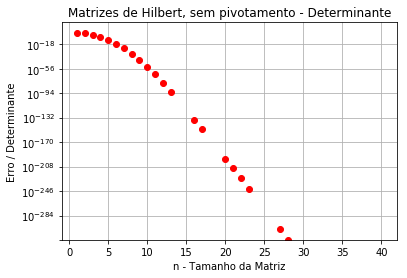

In [73]:
###############################
plt.yscale('log')
plt.plot(x, y1, 'ro')
# naming the x axis 
plt.xlabel('n - Tamanho da Matriz') 
# naming the y axis 
plt.ylabel('Erro / Determinante')   
# giving a title to my graph 
plt.title('Matrizes de Hilbert, sem pivotamento - Determinante')
# function to show the plot
plt.grid(True) 
plt.show()

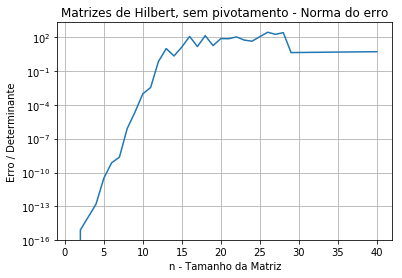

In [74]:
###############################
plt.yscale('log')
plt.plot(x, y2)
# naming the x axis 
plt.xlabel('n - Tamanho da Matriz') 
# naming the y axis 
plt.ylabel('Erro / Determinante')   
# giving a title to my graph 
plt.title('Matrizes de Hilbert, sem pivotamento - Norma do erro')
# function to show the plot
plt.grid(True) 
plt.show()

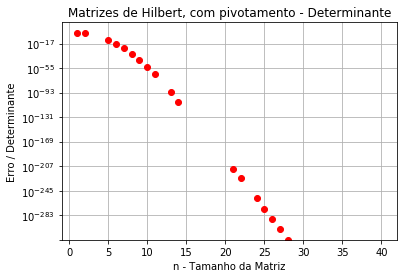

In [75]:
###############################
plt.yscale('log')
plt.plot(x, y3, 'ro')
# naming the x axis 
plt.xlabel('n - Tamanho da Matriz') 
# naming the y axis 
plt.ylabel('Erro / Determinante')   
# giving a title to my graph 
plt.title('Matrizes de Hilbert, com pivotamento - Determinante')
# function to show the plot
plt.grid(True)
plt.show()

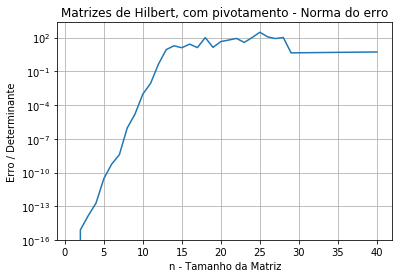

In [76]:
###############################
plt.yscale('log')
plt.plot(x, y4)
# naming the x axis 
plt.xlabel('n - Tamanho da Matriz') 
# naming the y axis 
plt.ylabel('Erro / Determinante')   
# giving a title to my graph 
plt.title('Matrizes de Hilbert, com pivotamento - Norma do erro')
# function to show the plot
plt.grid(True)
plt.show()

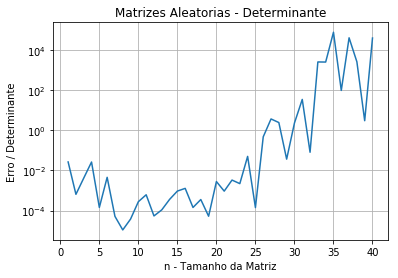

In [77]:
###############################
plt.yscale('log')
plt.plot(x, y5)
# naming the x axis 
plt.xlabel('n - Tamanho da Matriz') 
# naming the y axis 
plt.ylabel('Erro / Determinante')   
# giving a title to my graph 
plt.title('Matrizes Aleatorias - Determinante')
# function to show the plot
plt.grid(True)
plt.show()

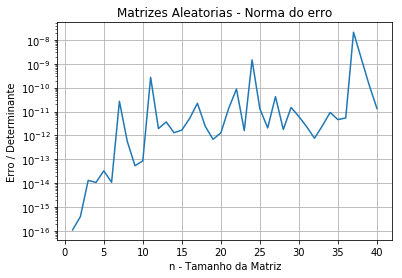

In [61]:
###############################
plt.yscale('log')
plt.plot(x, y6)
# naming the x axis 
plt.xlabel('n - Tamanho da Matriz') 
# naming the y axis 
plt.ylabel('Erro / Determinante')   
# giving a title to my graph 
plt.title('Matrizes Aleatorias - Norma do erro')
# function to show the plot
plt.grid(True)
plt.show()